<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/02_classification_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Machine Learning Model: basic text classification**

| | |
|------|------|
| Filename | 02_classification_test.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | September 4, 2024 |
| Aim(s) | Build, train and evaluate a neural network machine learning model that classifies movie reviews as positives or negatives. |
| Dataset(s) | IMDb Movie Reviews dataset [[1]](https://aclanthology.org/P11-1015.pdf)|
| Version | Python 3.10.12 - TensorFlow 2.17.1 |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. CPU execution is enough.
3. Run all and read comments.

---

#### **Motivation**

The IMDb Movie Reviews database - composed of over 50,000 movie reviews on internet - is used to built a binary classification model. In the last section, weights of the neural network are used to make correspondences and analogies between words.

#### **Outline**
* retrieve data & pre-processing
* Sequential API and loss function
* training and evaluation
* prediction
* exploration of the embedding space
* references

---



### **0. Input section**

The model has already been trained and the user can choose to used a pre-trained model (No) or to repeat the training phase (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [1]:
training_phase = 'No'

In [2]:
# @title **1.Python librairies & display utilities [RUN ME]**

from os import path, listdir                                                    # miscellaneous operating system interfaces
from re import escape                                                           # regular expressions
from shutil import rmtree                                                       # operations on files
from string import punctuation                                                  # string manipulation
import numpy as np                                                              # scientific computing
from tensorflow import constant, keras, strings, expand_dims, data, metrics     # machine learning models
from PIL import Image                                                           # image processing capabilities
import matplotlib.pyplot as plt                                                 # graphing package
import json

""" ############################################# """
""" Import Github files from TensorFlow repertory """
""" ############################################# """
def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # clone TensorFlow repertory
  training_curves = Image.open("TensorFlow_duplicata/99_pre_trained_models/02_classification_text/results_graph.jpeg") # see section 2.4
  model = keras.models.load_model('TensorFlow_duplicata/99_pre_trained_models/02_classification_text/02_classification_text.keras', custom_objects={'custom_standardization': custom_standardization}) # pre-trained model
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return training_curves, model

""" ##################################################### """
""" plot a random movie review with its label associated  """
""" ##################################################### """
def plot_text(text_batch):
  for text_batch, label_batch in text_batch:
      if label_batch.numpy()[0] == 0:
        print("Here's an extract from a negative review: \n", text_batch.numpy()[0])
      else:
        print("Here's an extract from a positive review: \n", text_batch.numpy()[0])

""" ######################################################### """
""" plot training curves for the training and validation set  """
""" ######################################################### """
def plot_evolution(history):
  loss_train, loss_val = history[0], history[2]
  acc_train, acc_val = history[1], history[3]
  epochs = range(1, len(acc_train) + 1)

  plt.subplot(2,1,1, xlabel='epoch', ylabel='loss')
  plt.plot(epochs, loss_train, label='Training', color='blue')
  plt.plot(epochs, loss_val, label='Validation', color='orange')
  plt.legend(loc='best', fontsize=10)
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.subplot(2,1,2, xlabel='epoch', ylabel='accuracy')
  plt.plot(epochs, acc_train, color='blue')
  plt.plot(epochs, acc_val, color='orange')
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.show()

""" #################### """
""" plot for section 5.3 """
""" #################### """
def plot_distribution_word(nb_word):
  plt.figure(figsize=(7,5))
  plt.hist(nb_word, bins=max(nb_word))
  plt.xlim([0, 1000]), plt.xticks(range(0,1100, 400)), plt.xlabel("# of words"), plt.ylabel("# of texts")
  plt.title("Number of text Vs. number of words")
  plt.show()

""" #################### """
""" plot for section 5.3 """
""" #################### """
def plot_histo(predictions, max_length):
  plt.figure(figsize=(5,5))
  plt.subplot(2,1,1, title=("max token = %d" %max_length), ylabel='# of text', ylim=[0, 7000])
  plt.hist(predictions, bins=50, cumulative=False)
  plt.subplot(2,1,2, xlabel="Model score", ylabel="# of text", ylim=[0,26000])
  plt.hist(predictions, bins=50, cumulative=True)
  plt.show()

""" #################### """
""" plot for section 5.3 """
""" #################### """
def plot_error_rate(unique_elements_error, ratio, max_length):
  plt.figure(figsize=(7,5))
  plt.hist(unique_elements_error, weights=100*ratio, bins=max(unique_elements_error), cumulative=False)
  plt.xlim([0, 1100]), plt.xticks(range(0,1200, 400)), plt.xlabel("# of words in the text"), plt.ylabel("Prediction error [%]"), plt.ylim([0, 110])
  plt.title("max token = %d" %max_length)
  plt.show()

---


### **2. Data retrieval and set generation**

###### **2.1. Stanford Sentiment Treebank Dataset**

The IMDb Movie Reviews is a database created for sentiment analysis in movie reviews. It contains movie reviews labeled with sentiment (positive or negative).


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = keras.utils.get_file("aclImdb_v1", url, extract=True, cache_dir='.', cache_subdir='')
dataset_dir = path.join(path.dirname(dataset), 'aclImdb')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


The extracted file `aclImdb` is composed of 5 folders:

*   `train`
    * `pos`: contains movie reviews with a positive sentiment (rating > 7/10)
    * `neg`: with a negative sentiment (rating < 4/10)
    * `unsup`: for unsupervised learning
*   `test`: contains movie reviews meant for testing
    * `pos`
    * `neg`
*   `README`: provides information about the dataset and how to use it
*   `imdb.vocab` and `imdbEr.txt` contain additional information about errors, URL website and specific annotations


In [4]:
listdir(dataset_dir) # check the file names in the aclImdb directory

['README', 'train', 'test', 'imdbEr.txt', 'imdb.vocab']

In [5]:
train_dir = path.join(dataset_dir, 'train') # path name of the "train" file in dataset_dir
remove_dir = path.join(train_dir, 'unsup') # remove the folder with unlabeled reviews for unsupervised learning
rmtree(remove_dir)

###### **2.2. Training and validation datasets**

Movie reviews are divided into 3 splits: `train`, `test` and `validation`. Only the validation set is not available into `aclImdb` and so it is created by using 20% of the training dataset.

These datasets are randomly shuffled ad then batches with the API utils. Datasets are stored in the data structures `tf.data.Dataset`. The advantage is that batches are not loaded into the immediate memory but only when they are called up.

In [6]:
batch_size = 32
raw_train_ds = keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='training', shuffle=True, seed=42) # 625 batches of 32 texts for training set randomly chosen
raw_val_ds = keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='validation', shuffle=True, seed=42) # 157 batches of 32 texts for validation set randomly chosen
raw_test_ds = keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batch_size) # 782 batches of 32 texts for test set

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [7]:
plot_text(raw_train_ds.take(1)) # show an example of movie review from the first training set batch

Here's an extract from a negative review: 
 b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'


---


### **3. Pre-processing & reformating data**

###### **3.1. Pre-processing layer**

The textual data is pre-processed and converted before being used by the model. Three crucial phases are established:
- standardization
- tokenization
- vectorization

The standardization step replaces upper case with lower case letters and removes html tags/punctuation characters.

In [8]:
punctuation = escape(punctuation)
print("The punctuation characters eliminated are: \n", " \n", punctuation)

The punctuation characters eliminated are: 
  
 !"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~


In [9]:
@keras.utils.register_keras_serializable()
def custom_standardization(input_text):
  no_uppercases = strings.lower(input_text) # upper cases --> lower cases
  no_html_uppercases = strings.regex_replace(no_uppercases, '<br />', ' ') # remove HTML strings
  no_punctuation_html_uppercases = strings.regex_replace(no_html_uppercases, '[%s]' % punctuation, '') # remove punctuation
  return no_punctuation_html_uppercases

The tokenization phase transformes words and strings into tokens. Finally, tokens are converted into integers at the vectorization phase. A dictionary of the 5,000 most frequently used words is created in order to match a token with the associated word [[1]](https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). The other little-used words - like actor names or non-evocative words - are not kept

In [10]:
max_features = 5000 # size of the dictionary
max_length = 500 # maximum number of words per review

vectorize_layer = keras.layers.TextVectorization(standardize=custom_standardization,
                                                 max_tokens=max_features,
                                                 output_sequence_length=max_length,
                                                 output_mode='int')

vectorize_layer.adapt(raw_train_ds.map(lambda x, y: x)) # dictionary creation with raw training texts (no label)

###### **3.2. Transformation visualization**

In [11]:
# get the integer tensor of a text after pre-processing

def token_to_int(raw_text):
  raw_text = next(iter(raw_text))[0]
  print("Review before tokenization and vectorization: \n", raw_text[0])
  print(" ")
  text_vectorized = expand_dims(raw_text, -1) #
  text_vectorized = vectorize_layer(text_vectorized)
  print("Review after tokenization and vectorization: \n", text_vectorized[0])

In [12]:
token_to_int(raw_train_ds)

Review before tokenization and vectorization: 
 tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer S

In [13]:
# get the word for a specific dictionary integer

def int_to_token(index):
  token = vectorize_layer.get_vocabulary()[index]
  print("The integer %d represents the token: %s" %(index, token))

In [14]:
int_to_token(7)

The integer 7 represents the token: is


---


### **4. Model and training**


###### **4.1. Dataset performances**

*   `prefetch`: prefetch next batch while training. Avoid the risk of bottleneck (GPU Vs. I/O). The prefetch buffer size is automatically set via AUTOTUNE.
*   `cache`: dataset fits in RAM.

In [15]:
AUTOTUNE = data.AUTOTUNE # prefetch buffer size parameter

raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

###### **4.2. Neural network architecture & compilation**

* Pre-processing layer `vectorize_layer`:
  * **Inputs:** strings of dimension `batch_size`
  * **Outputs:** an integer 2D tensor (`batch_size`, `max_length`)
  * **Comments:** if the number of string is less than `max_length`, the tensor is padded with zeros

* Embedding layer `Embedding`:
  * **Outputs:** a float 3D tensor (`batch_size`, `max_length`, `embedding_dim`)
  * **Comments:** each token is expressed as a float vector of dimension `embedding_dim`. All these vectors form a dictionary which is modified/adapted during the learning phase. Components of an embedding vector are considered as weights

* Pooling layer `GlobalAveragePooling1D`:
  * **Outputs:** a float 2D tensor (`batch_size`, `embedding_dim`)
  * **Comments:** average value of vector components

* Fully-connected layer `Dense`:
  * **Outputs:** a scalar between 0 (=negative sentiment) and 1 (=positive sentiment).
  * **Comments:** close to 0 = negative sentiment, close to 1 = positive sentiment, close to 0.5 = no clear opinion

The binary cross-entropy is used as loss function of the binary classification. With the sigmoid function applied to the model output, `BinaryCrossEntropy` is defined with `from_logits=False`.

In [16]:
def create_model():
  embedding_dim = 16
  model = keras.Sequential([vectorize_layer, # pre-processing layer
                            keras.layers.Embedding(input_dim = max_features, output_dim = embedding_dim),
                            keras.layers.Dropout(0.2),
                            keras.layers.GlobalAveragePooling1D(),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(1, activation='sigmoid')
                            ], name="classification_text_model")

  model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=[metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.5)]
                )

  return model

###### **4.3. Training phase**


In [17]:
def train_model(model, training_data, validation_data, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, validation_freq=1, callbacks=[stop_early, cp_callback], **kwargs)

  return log.history["loss"], log.history["binary_accuracy"], log.history["val_loss"], log.history["val_binary_accuracy"]

2 callbacks are defined and are used during the training phase:
*   `stop_early`: stop training when a `val_binary_accuracy` has stopped improving.
*   `cp_callback`: save the model when `val_binary_accuracy` is maximum.




In [18]:
epochs = 100

if training_phase == "Yes":
  model = create_model()
  stop_early = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True, min_delta=0.001)

  cp_callback = keras.callbacks.ModelCheckpoint(filepath='02_classification_text.keras',
                                          monitor = "val_binary_accuracy",
                                          save_best_only = True,
                                          mode = "max",
                                          save_weights_only=False,
                                          verbose=0)

  classifier_accuracy = train_model(model, raw_train_ds, raw_val_ds, epochs=epochs)
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), np.argmax(classifier_accuracy[3])+1))

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 547, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 547 (delta 146), reused 94 (delta 94), pack-reused 368 (from 1)
Receiving objects: 100% (547/547), 132.83 MiB | 25.70 MiB/s, done.
Resolving deltas: 100% (273/273), done.


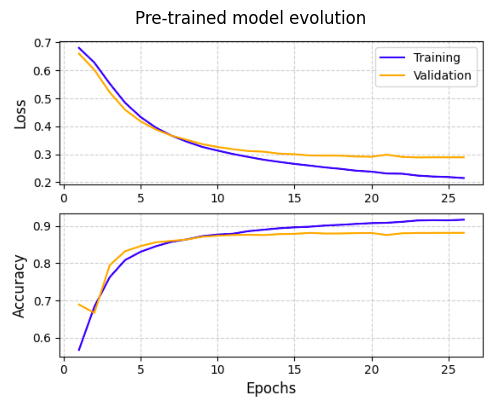

In [19]:
if training_phase == 'Yes':
  plot_evolution(classifier_accuracy)
else:
  training_curves, model = get_github_files() # get the pre-trained model and training curves
  plt.imshow(training_curves), plt.title("Pre-trained model evolution"), plt.axis("off")

The precision/loss of the 2 sets evolve conjointly. The callback `stop_early` stopped the training when `val_binary_accuracy` has been stabilized since 10 epochs.

---


### **5. Evaluation and limitations**


###### **5.1. Evaluation**


In [20]:
loss_test, accuracy_test = model.evaluate(raw_test_ds, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(loss_test, 100*accuracy_test))

Test loss function value 0.3 and test accuracy value 88.5 %


The model can be used to recognize the sentiment of new/fictitious movie review.

###### **5.2. Predictions**

In [21]:
my_review = ["This movie was terrible and boring. Most of scenes were violents and useless."] # please write your own review in English

In [22]:
examples = constant(my_review)

prediction = model.predict(examples, verbose=0)
if prediction < 0.5:
  print("The movie looks pretty bad. (score model: ", round(prediction[0][0], 1), ")")
else:
  print("Great movie, go see it in the cinema! (score model: ", round(prediction[0][0], 1), ")")

The movie looks pretty bad. (score model:  0.1 )


###### **5.3. Error analysis**

Next, the model's prediction errors are analyzed to determine the model's limits.

In [23]:
predictions = model.predict(raw_test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


Predictions were made on a set of reviews from the test set. The majority of these texts are between 100 and 400 words long, as shown by the following distribution of the number of reviews Vs. number of words.

In [24]:
labels = []
texts = []
nb_word = []

for text, label in raw_test_ds.take(int(data.experimental.cardinality(raw_test_ds))):
    for i in range(len(text)):
        labels.append(label.numpy()[i])
        texts.append(text.numpy()[i])
        nb_word.append(len(text.numpy()[i].split())) # count the number of words

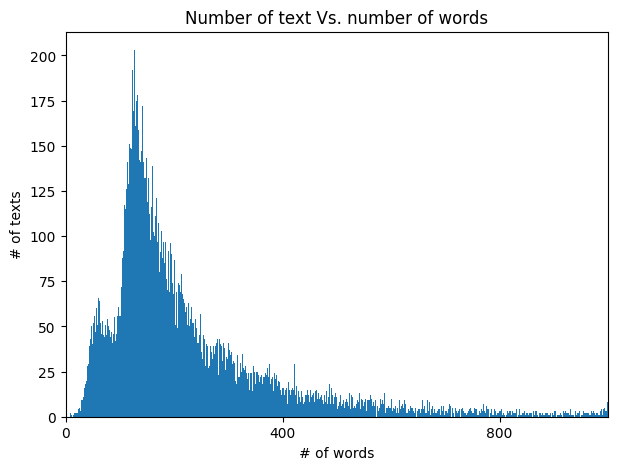

In [25]:
plot_distribution_word(nb_word)

The distribution of the 25,000 predictions shows that the model tends to answer in a binary way and with little hesitation. Around 75% of test texts have a predicted score below 0.3 (bad/terrible movie) or above 0.7 (correct/great movie).

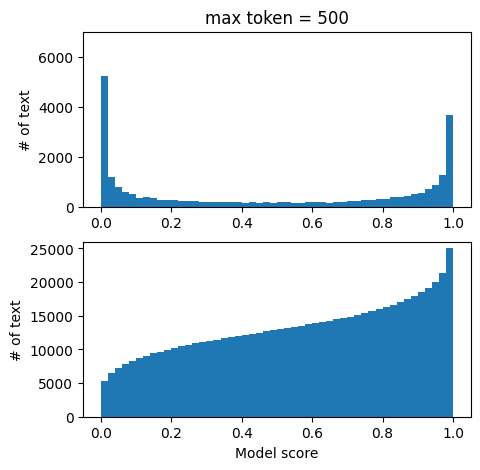

In [26]:
plot_histo(predictions, max_length)

Two additional training runs were completed for different maximum word counts per review: `max_length = 250` and `max_length = 2000`. It seems that the more words the reviews have, the less binary and extreme the model's predictions will be. However, a lack of improvement in the accuracy of model predictions on the test set is observed for `max_length = 2000` (88.5%) and `max_length = 500` (88.5% too). The test accuracy for `max_length = 100` is equal to  86.4%.

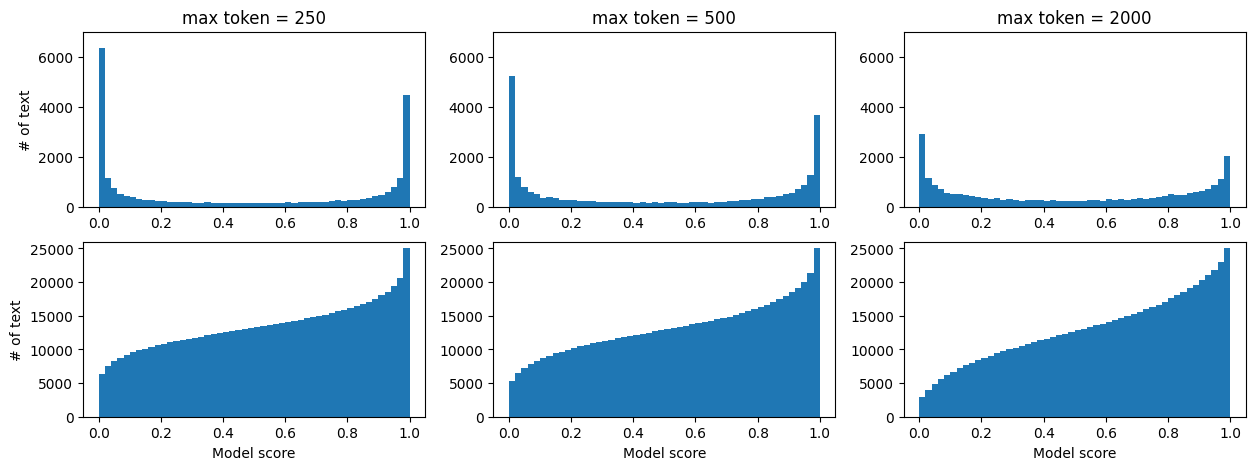

The error rate of model's predictions is analyzed according to the word count, to see whether the quantity of words has an impact on predictions.

In [27]:
errors = (np.round(predictions[:,0], 0) - np.array(labels) != 0) # truncate scores to obtain either 0 or 1
y_prediction_error = predictions[errors] # get wrong labels
y_test_error = np.array(labels)[errors] # get actual labels
nb_word_error = np.array(nb_word)[errors]

In [28]:
unique_elements_test, counts_elements_test = np.unique(nb_word, return_counts=True)
unique_elements_error, counts_elements_error = np.unique(nb_word_error, return_counts=True)

In [29]:
mask = np.isin(unique_elements_test, unique_elements_error)
ratio = counts_elements_error/counts_elements_test[mask]

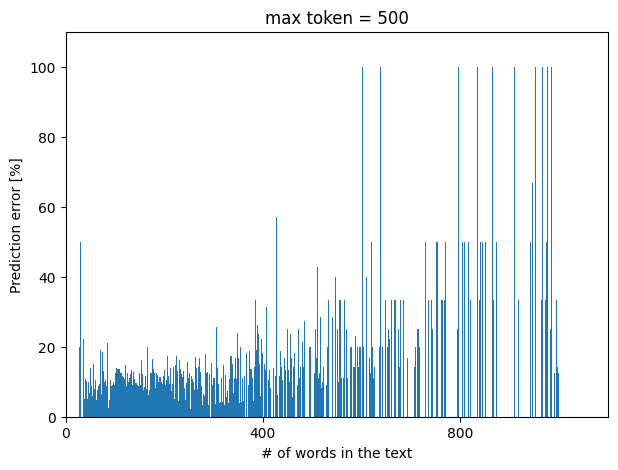

In [30]:
plot_error_rate(unique_elements_error, ratio, max_length)

Mispredicted texts and labels are collected and expressed according to the number of words contained in the review. For `max_length = 500`, less than 20% of short and medium-length reviews are incorrectly predicted. Same conclusion for `max_length = 250` and `max_length = 2000`. Several reasons can be given:
*   there are very few long reviews, so one bad prediction is more serious for a set of 1/2 long texts than for a dozen short ones.
*   long reviews are generally written by film experts, using a richer vocabulary and therefore less present in the model dictionary.  
*   parameter `max_length` has a significant impact on predictions. The higher the number of words retained, the less error the model will make for long texts. However, the accuracy of the test set remains unchanged.


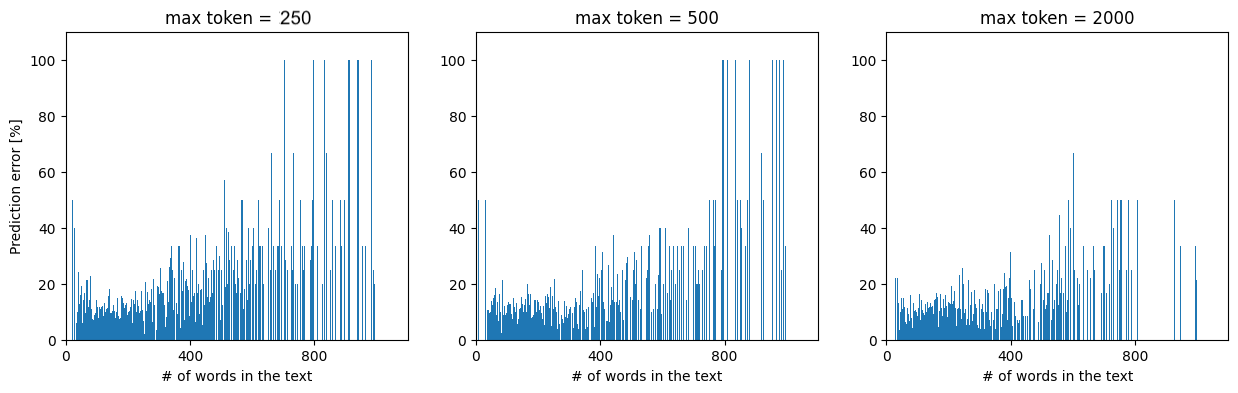

Finally, in analyzing the poorly predicted texts, it would seem that lack of context and attention would cause mispredictions. Example with a text misinterpreted by the model:

"Complete entertainment!. Although there are many strange things in the movie that the fairy tale itself doesn't have them including the autumn characters (mother and daughter), the general concept rocks."

The true label is positive, while the model predicts a negative review. A negative comment was inserted into this positive review without affecting the general author's opinion. A lack of context and model attention produced this misclassification.



In [31]:
i = 100
x_test_error = np.array(texts)[errors] # get actual labels
true_label, predicted_label = y_test_error[i], y_prediction_error[i,0]
print("True label: %0.0f" %true_label)
print("Predicted label: %0.0f" %predicted_label)
x_test_error[i]

True label: 1
Predicted label: 0


b'L\'OSSESSA, also known as THE TORMENTED or THE SEXORCIST, or the ridiculously titled THE EERIE MIDNIGHT HORROR SHOW, is a forgotten EXORCIST rip-off which contains one of the best horror moments I\'ve ever seen. The scene is when the crucifix comes alive. This great spooky scene is unforgettable and totally effective (great FXs). It\'s a shame the rest of the movie doesn\'t maintain the level of creepiness exemplified during that scene.<br /><br />This is one of the most frustrating movies ever. Imagine the producers deciding to to make an EXORCIST copy but while making it, they actually succeed in creating something truly original (a possessed sculpture of crucified man, which is shocking when you think about it) but then completely forgets their original idea in order to make a boring and uninspired EXORCIST rip-off. Had the film continued with the possessed sculpture concept (with the characters trying to destroy it, etc), this film would have rocked. But once the girl becomes pos

**With over 88% accuracy, the text classification model is quiet reliable. It's able to capture the author's feeling with an review. However, the model has limitations for long texts and those requiring context.**

---


### **6. Go further: the embedding dictionary**

The weights of the embedding layer - i.e. the embedding vectors - are extracted and added to a dictionary with their definition - i.e. the associated word.

In [32]:
embeddings_vector = model.layers[1].get_weights()[0] # get the 5,000 vectors of the embedding layer
print("The dictionary size is equal to:",(np.shape(embeddings_vector)))
dictionary_embedding = {vectorize_layer.get_vocabulary()[i]:embeddings_vector[i] for i in range(max_features)} # built the embedding dictionary

The dictionary size is equal to: (5000, 16)


In [33]:
with open('02_classification_text_dict.json', 'w') as f:
    modified_dict = {k: v.tolist() for k, v in dictionary_embedding.items()}
    json.dump(modified_dict, f)

The embedding dictionary can be visualized as a 16-dimensional space where each of the 5,000 words is an element of this space. For example, the word "good" corresponds to:

In [34]:
dictionary_embedding["good"]

array([-0.7068291 , -0.8950667 ,  0.7667451 ,  0.6835332 , -0.85558134,
        0.8109165 , -0.94413424,  0.784986  ,  0.86634517,  0.66729796,
       -0.71538705,  0.81901556,  0.92852104, -0.7565169 , -0.7710601 ,
        0.76415795], dtype=float32)

Embedding projector software (https://projector.tensorflow.org/?hl=fr) provides a comprehensive representation of this space using the PCA dimension reduction method. The images below are taken from this software.

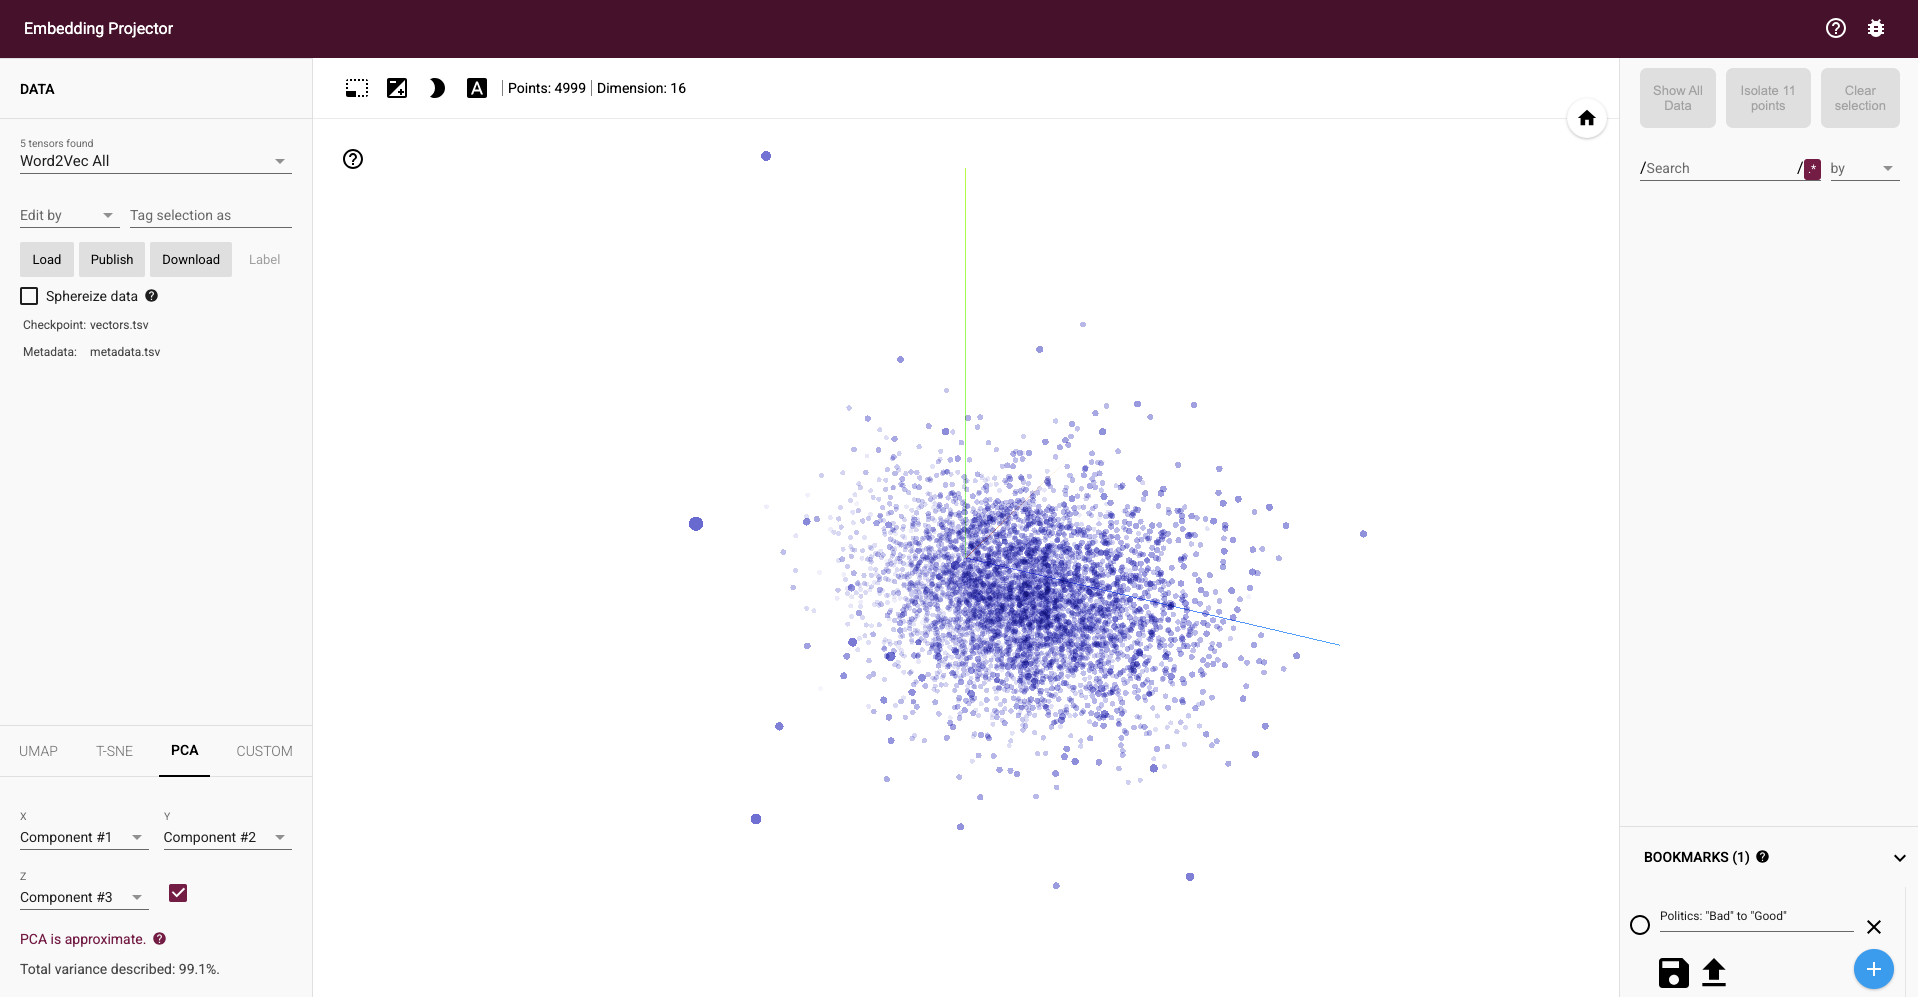

By applying a spherical transformation, 2 word clusters are created: words expressing positive and negative feelings.

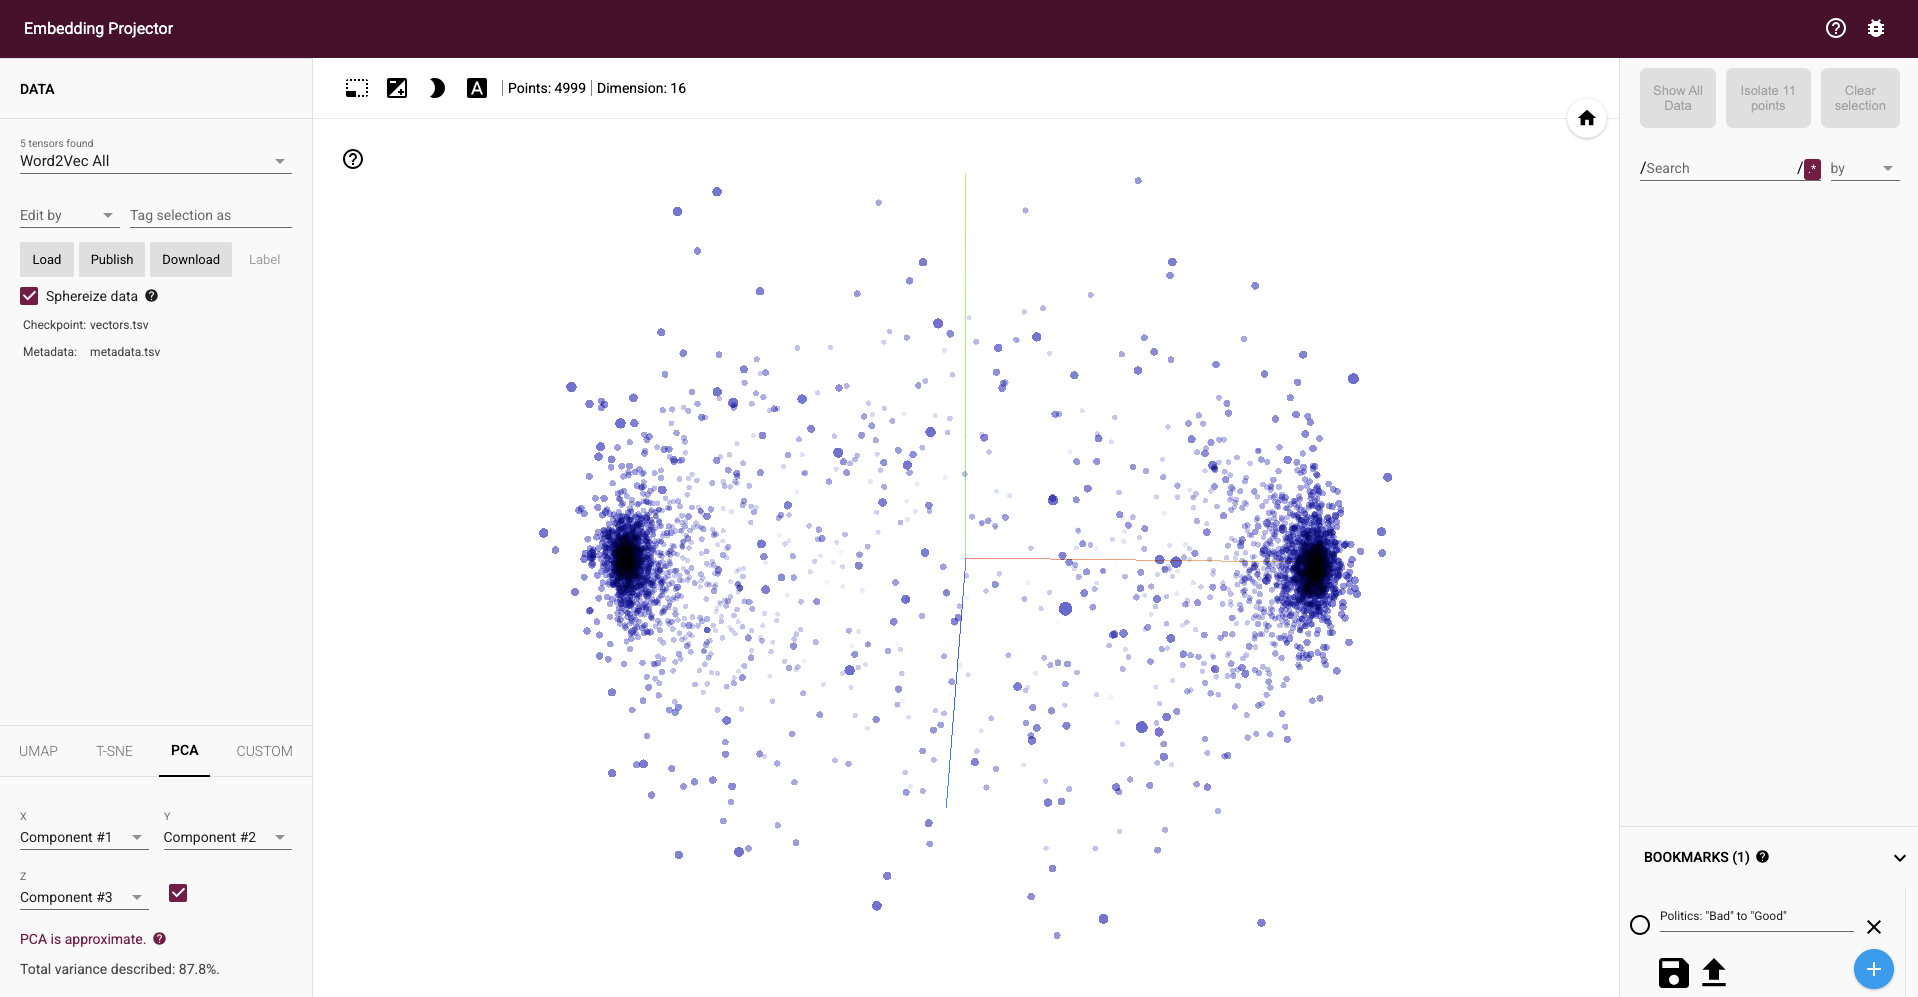

A notion of distance can be introduced in the embedding space
[[4]](https://www.cs.toronto.edu/~lczhang/360/lec/w05/w2v.html) and therefore, two words are "close" to each other in the embedding space if the distance between them is low.

A second and reliable quantity to measure similarity is the cosinus similarity. Two vectors have a cosine similarity of 1, two orthogonal and independant vectors have a similarity of 0, and two opposite vectors have a similarity of -1.

In [35]:
# get the distance between two elements in the embedding space

def get_distance(token1, token2):
  p1 = dictionary_embedding[token1]
  p2 = dictionary_embedding[token2]
  distance = np.linalg.norm(p2-p1)
  return distance

# get the cosinus similarity between two elements in the embedding space

def get_cosinus_similarity(token1, token2):
  p1 = dictionary_embedding[token1]
  p2 = dictionary_embedding[token2]
  dot_product = np.dot(p1, p2)
  magnitude_1 = np.linalg.norm(p1)
  magnitude_2 = np.linalg.norm(p2)
  cosine_sim = dot_product / (magnitude_1 * magnitude_2)
  return cosine_sim

In [36]:
get_distance("good", "terrible")

18.659864

In [37]:
get_cosinus_similarity("good", "terrible")

-0.9933427

In [38]:
get_distance("disappointing", "terrible")

1.940095

In [39]:
get_cosinus_similarity("disappointing", "terrible")

0.99881816

With the notion of distance and cosinus similarity, it's possible to explore the entire embedding dictionary to find the words closest to a specific word.

In [40]:
# get elements closest to a specific element in the embedding space

def get_synomym(token, n, used_distance=True):
  p1 = dictionary_embedding[token]
  candidate_list = {} # stores n synonyms
  for i in range(1, 1000): # only the first 1000 words of the embedding dictionary are searched
    token_candidate = vectorize_layer.get_vocabulary()[i]
    if used_distance == True: candidate_list[token_candidate] = get_distance(token, token_candidate)
    else: candidate_list[token_candidate] = get_cosinus_similarity(token, token_candidate)

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])

  if used_distance == True: synonym_list = sorted_items[1:n+1]
  else: synonym_list = sorted_items[-(n+1):-1]
  words = [(item[0], item[1]) for item in synonym_list]
  return print(words)

In [41]:
word = "terrible"
nb = 10
get_synomym(word, nb, used_distance=False)

[('unfortunately', 0.9995481), ('worst', 0.9995617), ('attempt', 0.9995657), ('worse', 0.9995829), ('avoid', 0.9995875), ('stupid', 0.99959904), ('waste', 0.9996151), ('awful', 0.9996258), ('ridiculous', 0.9997313), ('poor', 0.9997536)]


When comparing with Embedding projector, some words are in common and others are not, because in the function `get_synonym`, only the first 1000 words in the dictionary are searched.

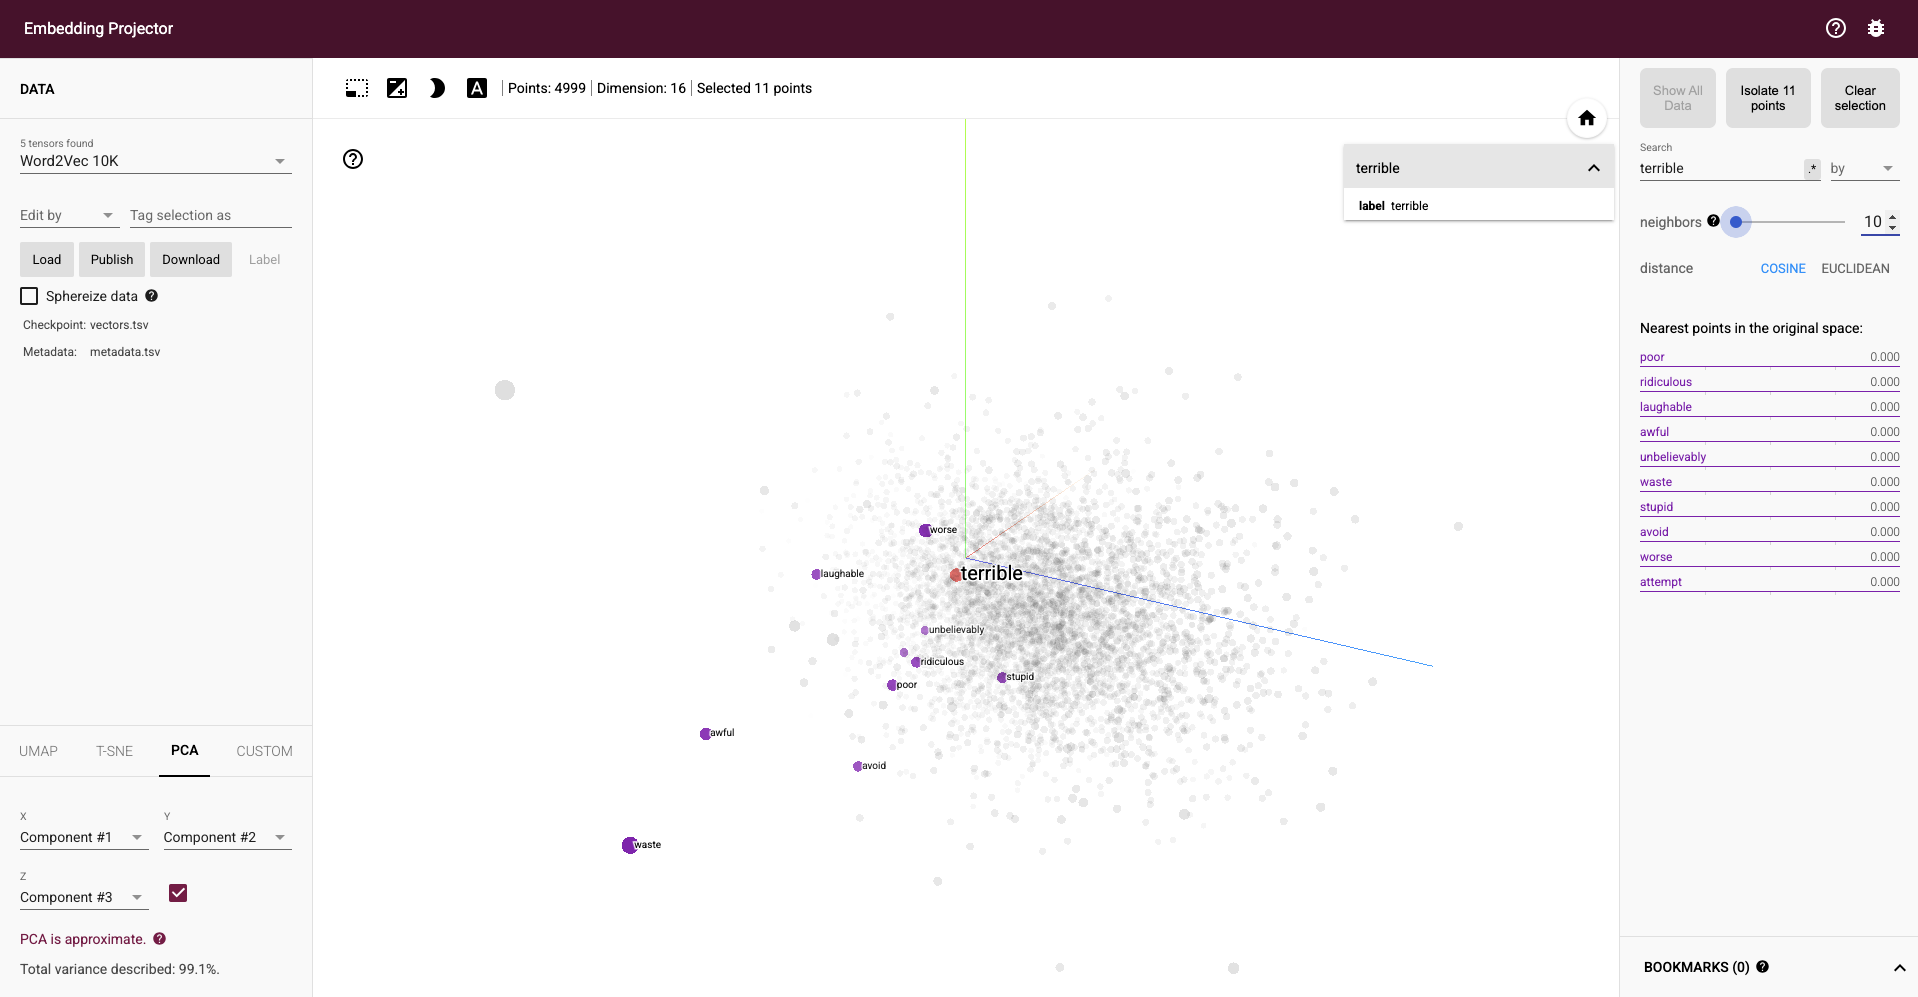

Finally, analogies between words can be tested.

In [42]:
def get_analogy(vector, n):
  candidate_list = {} # stores n synonyms
  for i in range(1, 5000):
    token_candidate = vectorize_layer.get_vocabulary()[i]
    vector_candidate = dictionary_embedding[token_candidate]
    candidate_list[token_candidate] = sum(abs(vector - vector_candidate))

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])
  synonym_list = sorted_items[0:n]
  words = [item[0] for item in synonym_list]
  print(words)

In [43]:
analogy = dictionary_embedding["funny"] - dictionary_embedding["nice"] + dictionary_embedding["terrible"]
get_analogy(analogy, 5)

['awful', 'poorly', 'boring', '410', 'worse']


**The richness of the dictionary is adequate for a simple positive/negative classification model, but remains limited when exploring the embeddings space. Some of the words proposed are not really synomyms, opposites or good analogies. To complete the dictionary, it's necessary to train the model with new collections of texts, different from the cinema theme, to introduce new words. Attention mechanism helps to achieve higher levels of precision**



---


### **7. References**


| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://aclanthology.org/P11-1015.pdf) | IMDB dataset | Andrew L. Maas & al | dataset & paper | - |
|[[2]](https://www.tensorflow.org/tutorials/keras/text_classification?hl=fr) | Classification de texte de base | TensorFlow | dataset | - |
|[[3]](https://www.tensorflow.org/guide/data_performance?hl=fr) | De meilleures performances avec l'API tf.data | TensorFlow | Tutoriels | - |
|[[4]](https://www.cs.toronto.edu/~lczhang/360/lec/w05/w2v.html) | Word2Vec and GloVe Vectors | Toronto university | website | - |